In [1]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

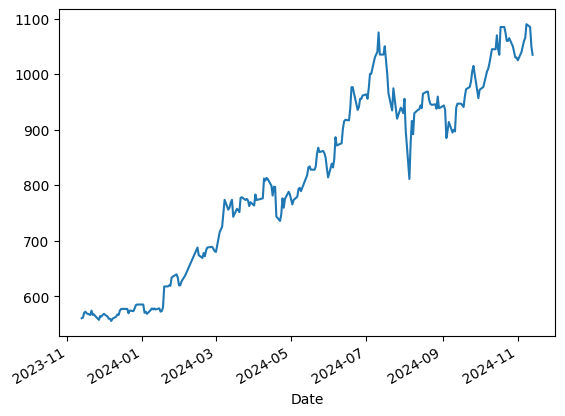

In [2]:
taiwan_2330_stock = yf.Ticker("2330.TW")      ## 我以台積電作為我的股票
data  = taiwan_2330_stock.history(period="1y")   ## 我抓取的時間是一年
data['Close'].plot() # 畫出收盤價圖片

close_prices = data['Close']  ## 選擇收盤價作為預測目標

close_prices_last = close_prices[ : -10]
close_prices_next = close_prices[-10: ]

feature = []
label = []

In [3]:
for i in range( len(close_prices.values) - 29) :
    feature.append([])
    label.append([])
    feature[i].append(close_prices.values[i: i+20])
    label[i].append(close_prices.values[i+20: i+30])

train_size = int(len(feature) -1)

train_x, test_x =  feature[ :train_size], feature[train_size: ]
train_y, test_y   =  label[ :train_size], label[train_size: ]
train_x, test_x , train_y, test_y = torch.FloatTensor(train_x) , torch.FloatTensor(test_x), torch.FloatTensor(train_y), torch.FloatTensor(test_y)


<ipython-input-3-6b4abf1eb8fc>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  train_x, test_x , train_y, test_y = torch.FloatTensor(train_x) , torch.FloatTensor(test_x), torch.FloatTensor(train_y), torch.FloatTensor(test_y)


In [4]:
input_size = 20
class LSTM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size = input_size, hidden_size=64, num_layers=2, batch_first = True)
        self.linear = nn.Linear(64, 10)
        #self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x, _ = self.lstm(x)
        #x = self.dropout(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [5]:
model = LSTM_Model()
loss_fn = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters())
n_epochs = 2500

In [6]:
# 訓練迴圈
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_x)
    loss = loss_fn(output, train_y)
    loss.backward()
    optimizer.step()

    # 每 100 個 epoch 打印一次損失
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([214, 1, 10])) that is different to the input size (torch.Size([214, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100/2500, Loss: 571246.5625
Epoch 200/2500, Loss: 490537.5625
Epoch 300/2500, Loss: 425271.5312
Epoch 400/2500, Loss: 367496.5625
Epoch 500/2500, Loss: 315234.4375
Epoch 600/2500, Loss: 267823.1562
Epoch 700/2500, Loss: 225004.8438
Epoch 800/2500, Loss: 186655.5312
Epoch 900/2500, Loss: 152691.8594
Epoch 1000/2500, Loss: 123037.4922
Epoch 1100/2500, Loss: 97606.9062
Epoch 1200/2500, Loss: 76296.1250
Epoch 1300/2500, Loss: 58972.5352
Epoch 1400/2500, Loss: 45461.6797
Epoch 1500/2500, Loss: 35526.8516
Epoch 1600/2500, Loss: 28837.3477
Epoch 1700/2500, Loss: 24921.5117
Epoch 1800/2500, Loss: 23113.9707
Epoch 1900/2500, Loss: 22567.6172
Epoch 2000/2500, Loss: 22489.9785
Epoch 2100/2500, Loss: 22486.9023
Epoch 2200/2500, Loss: 22486.8867
Epoch 2300/2500, Loss: 22486.8887
Epoch 2400/2500, Loss: 22486.8887
Epoch 2500/2500, Loss: 22486.8867


In [7]:
## 切換模型到評估模式
model.eval()

## 使用新的數據進行預測
with torch.no_grad():  ## 關閉梯度追蹤，減少記憶體使用
    predictions = model(test_x)


[829.13983 831.319   833.4564  835.66864 837.89044 840.1452  842.42346
 844.81854 847.19025 849.4352 ]


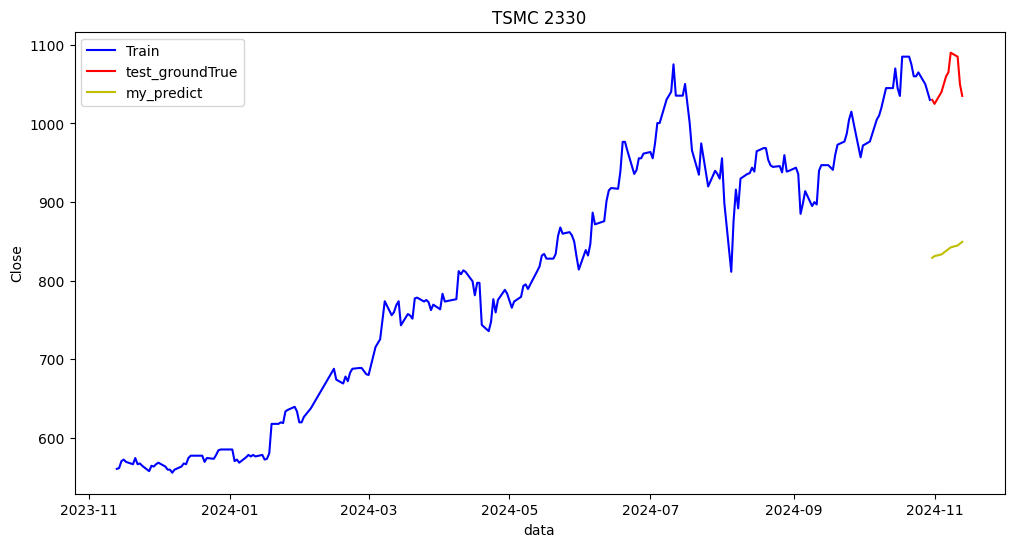

In [8]:
predictions = predictions.numpy()  ## 如果 x_test 是 CPU 張量


predictions_data = np.array(predictions).flatten()  ## 將資料展平成一維
print(predictions_data)
#predictions_data = predictions_data +200 #偷機摸狗
predictions_data = pd.Series(predictions_data[0:len(close_prices_next)], index= close_prices_next.index, name='Date')


import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(close_prices_last, 'b', label='Train')
plt.plot(close_prices_next, 'r', label='test_groundTrue')
plt.plot(predictions_data, 'y', label='my_predict')
plt.title('TSMC 2330')
plt.xlabel('data')
plt.ylabel('Close')
plt.legend()
plt.show()